In [1]:
import torch
from pathlib import Path


from model_architectures import MonaiDDPM
device = "cuda:0" if torch.cuda.is_available() else "cpu"


CONDITIONAL = True
RESOLUTION = 256
T = 1_000     

root = Path("/home/locolinux2/U24_synthesis/lightning_synthesis/experiments")
# ckpt  = "/home/locolinux2/U24_synthesis/lightning_synthesis/experiments/049_cDDPM_depth5_fixedScaling_256x256/checkpoints/epoch=22-step=7843.ckpt" # FID = 8.18 at guidance scale 3
ckpt  = "053_DDPM__DataArtifactsRemoved___256x256/checkpoints/epoch=04-step=1435.ckpt"
ckpt  = "054_DDPM_default512_256x256/checkpoints/epoch=04-step=1435.ckpt" # FID @ GS 0: 7.38
ckpt  = "057_DDPM_seed2025_cropped_256x256/checkpoints/epoch=04-step=1435.ckpt"
ckpt = "063_DDPM_contrast-aug-20percent_256x256/checkpoints/epoch=04-step=1435.ckpt"
ckpt = "092_DDPM_MS-SSIM_10perc_HF_5perc_256x256/checkpoints/epoch=18-step=2736.ckpt" # GOLD
# ckpt = "106_DDPM_3loss_binary_try/checkpoints/epoch=18-step=2736.ckpt" # functional binary
ckpt = "107_DDPM_3loss_4class_retry/checkpoints/epoch=17-step=3456.ckpt"
ckpt = "113_DDPM_binary_epochwise_balanced/checkpoints/epoch=30-step=1116.ckpt" # dynamic epoch-wise data balancing 
ckpt = "114_DDPM_binary_epochwise_balanced_12vs56/checkpoints/epoch=22-step=1771.ckpt" # more data
ckpt = "121_DDPM_binary_21fixedmatching_12vs56/checkpoints/epoch=20-step=1827.ckpt" #  just to check how epoch-wise sampling affects things
ckpt = "120_DDPM_binary_21perepoch_12vs56/checkpoints/epoch=19-step=1740.ckpt" # seems decent! Even guidance scale 4 gets 70% accuracy.
ckpt = "123_DDPM_binary_11_5perepoch_12vs56/checkpoints/epoch=20-step=1512.ckpt" # 
ckpt = "124_DDPM_binary_11perepoch_12vs56/checkpoints/epoch=26-step=1566.ckpt"
ckpt = "140_DDPM_augmentationsgeometric_binary_11perepoch_12vs56/checkpoints/epoch=26-step=1566.ckpt" # let's see augmentations doin stuff
# ckpt = "144_CMMD_DDPM_augmentationsgeometric_binary_13fixed_12vs56/checkpoints/epoch=12-step=962.ckpt"
# ckpt = "145_CMMD_DDPM_augmentationsNone_binary_11balancing_12vs56/checkpoints/epoch=29-step=990.ckpt"

ckpt_path = root /ckpt 
model = MonaiDDPM.load_from_checkpoint(
    ckpt_path
).to(device).eval()

Error importing huggingface_hub.file_download: 'Version'


/home/locolinux2/miniconda3/envs/U24/lib/python3.9/site-packages/generative/networks/layers/vector_quantizer.py:86: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)
/home/locolinux2/miniconda3/envs/U24/lib/python3.9/site-packages/generative/networks/layers/vector_quantizer.py:124: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @torch.cuda.amp.autocast(enabled=False)


Loss function using 0.85 MSE and 0.1 similarity measure MultiScaleStructuralSimilarityIndexMeasure(), and 0.050000000000000044 high frequency
Initialized conditional model.


In [2]:
# %load_ext tensorboard
# %tensorboard --logdir logs/ --port 6007

In [3]:
import torch, random, glob, os, nibabel as nib
import numpy as np
from torchvision import transforms
from torchvision.utils import make_grid
from PIL import Image
import matplotlib.pyplot as plt
# ── reproducibility ─────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)   # safe even if CPU-only
# ── paths ───────────────────────────────────────────────────────────
ROOT_REAL = "/mnt/d/Datasets/EMBED/EMBED_binary_256x256/train/original"
if "CMMD" in ckpt:
    ROOT_REAL = "/mnt/d/Datasets/CMMD/CMMD_binary_256x256/train/original"

LABELS       = {0: "benign", 1: "malignant"}
GUIDE_SCALES = [0, 4, 8]
N_PER_CLASS  = 5
RESOLUTION   = 256
device       = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------------------------------------------
# helper: load NIfTI slice → 1-channel PIL image
def load_nii_as_pil(path):
    arr = nib.load(path).get_fdata().astype(np.float32)
    if arr.ndim == 3:         # (H,W,1) or (H,W,D) keep first slice
        arr = arr[..., 0]
    # min-max normalise to 0-255 for PIL
    arr = (255 * (arr - arr.min()) / (arr.ptp() + 1e-8)).astype(np.uint8)
    return Image.fromarray(arr, mode="L")

# torchvision transform
to_tensor = transforms.Compose([
    transforms.ToTensor(),                 # → [0,1]
    transforms.Normalize(0.5, 0.5),        # → [-1,1]
])

# ── 0.  real rows ───────────────────────────────────────────────────
real_rows = []
for lbl, folder in LABELS.items():
    nii_paths = glob.glob(
        os.path.join(ROOT_REAL, folder, "*", "slice.nii.gz")
    )
    if len(nii_paths) < N_PER_CLASS:
        raise RuntimeError(f"Need {N_PER_CLASS} slices in {folder}")
    picks = random.sample(nii_paths, N_PER_CLASS)

    tensors = []
    for p in picks:
        img = to_tensor(load_nii_as_pil(p))   # (1,H,W) in [-1,1]
        tensors.append((img + 1) / 2)         # back → [0,1] for display
    real_rows.append(torch.stack(tensors))
real_row = torch.cat(real_rows, 0)            # (8,1,H,W)

# ── 1.  fake rows (guidance 0 & 8) ─────────────────────────────────-
fake_rows = []
with torch.no_grad(), torch.autocast(device_type="cuda", dtype=torch.float16):
    for gs in GUIDE_SCALES:
        per_label = []
        for lbl in LABELS:
            per_label.append(
                model.sample(N=N_PER_CLASS, label=lbl,
                             size=RESOLUTION, guidance_scale=gs).cpu()
            )
        fake_rows.append(torch.cat(per_label, 0))   # (8,1,H,W)




100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:27<00:00,  1.15it/s]


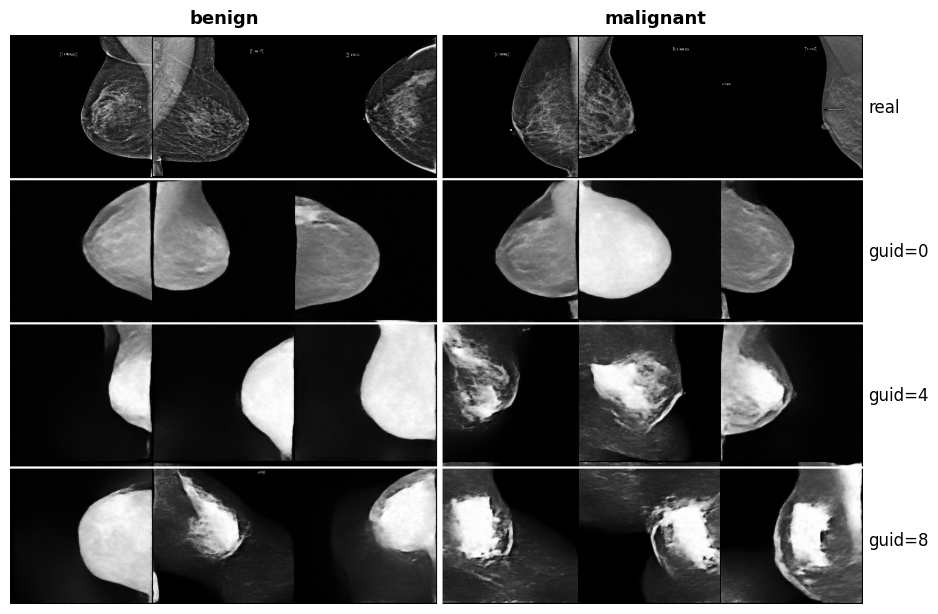

Saved grid → plots/140_DDPM_augmen-comparison_grid-vis3.pdf


In [4]:
# ------------------------------------------------------------------
VIS_PER_CLASS = 3            # <— how many per label you want to display
assert VIS_PER_CLASS <= N_PER_CLASS

# keep positions 2,3,4  (0-based)  → drops the first two
KEEP_IDX = [2, 3, 4]          # edit this to any list or range
N_PER_CLASS = 5               # total sampled earlier

assert max(KEEP_IDX) < N_PER_CLASS, "index out of range"
VIS_PER_CLASS = len(KEEP_IDX)          # derived automatically

def trim_row(t, keep_idx=KEEP_IDX, n_orig=N_PER_CLASS):
    """
    t shape: (2*n_orig, 1, H, W)  [label-0 … label-1]
    returns: (2*len(keep_idx), 1, H, W) with selected positions.
    """
    keep0 = torch.tensor(keep_idx)                       # label-0 offsets
    keep1 = keep0 + n_orig                               # label-1 offsets
    idx   = torch.cat([keep0, keep1])
    return t[idx]

# apply to real row and every fake row
rows = [trim_row(real_row)]
rows += [trim_row(r) for r in fake_rows]

# ---------------- stack & plot -------------------------------------
n_rows = len(rows)
n_cols = len(LABELS) * VIS_PER_CLASS          # 6 columns if keep=3

all_imgs = torch.cat(rows, 0)
grid = make_grid(all_imgs, nrow=n_cols, padding=2, value_range=(0, 1))
grid_img = grid.permute(1, 2, 0).cpu().numpy()

# ------- horizontal separators (rows) ---------------------------------
BAR_PX  = 4
PADDING = 2
ROW_H   = RESOLUTION + PADDING          # distance from one row-top to next

for k in range(1, n_rows):              # k = 1 … n_rows-1
    y = PADDING + k * ROW_H + (k - 1) * BAR_PX
    grid_img[y : y + BAR_PX, :, :] = 1.0

# ------- vertical separator (between benign | malignant) --------------
VBAR_PX     = 10                        # thicker than row bars
COL_GROUP_W = RESOLUTION + PADDING      # width of one image + right padding
x = PADDING + VIS_PER_CLASS * COL_GROUP_W   # left edge of first malignant image
grid_img[:, x : x + VBAR_PX, :] = 1.0       # paint white stripe

# ------- plot -------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 2.8 * n_rows))
ax.imshow(grid_img, cmap="gray")
ax.axis("off")

# column labels ------------------------------------------------------
x_vert       = x                                       # from earlier code
x_benign     = PADDING + VIS_PER_CLASS * COL_GROUP_W / 2
x_malignant  = x_vert + VBAR_PX + VIS_PER_CLASS * COL_GROUP_W / 2
ax.text(x_benign,    -15, "benign",    ha="center", va="bottom",
        fontsize=13, fontweight="bold")
ax.text(x_malignant, -15, "malignant", ha="center", va="bottom",
        fontsize=13, fontweight="bold")

# row labels (unchanged) --------------------------------------------
row_labels = ["real"] + [f"guid={g}" for g in GUIDE_SCALES]
for idx, txt in enumerate(row_labels):
    y_mid = PADDING + idx * (ROW_H + BAR_PX) + ROW_H // 2
    ax.text(grid_img.shape[1] + 10, y_mid, txt,
            va="center", fontsize=12)

fname = f"plots/{ckpt[:15]}-comparison_grid-vis{VIS_PER_CLASS}.pdf"
plt.savefig(fname, bbox_inches="tight")
plt.show()
print(f"Saved grid → {fname}")



In [5]:
for img in samples:
    print(samples.max(), samples.min())

NameError: name 'samples' is not defined

# In case you need to load old ones:

In [6]:
import torch, pathlib, datetime, os

# ── rows BEFORE trimming ------------------------------------------
rows_raw = [real_row] + fake_rows              # keep full 2×N_PER_CLASS each

# ── build a tidy dict  --------------------------------------------
rows_dict = {
    "real"      : rows_raw[0].cpu(),                   # tensor (2N,1,H,W)
    "guidances" : {g: r.cpu()                         # {scale: tensor}
                   for g, r in zip(GUIDE_SCALES, rows_raw[1:])},
    "meta" : {
        "labels"        : LABELS,                     # id→name mapping
        "n_per_class"   : N_PER_CLASS,
        "resolution"    : RESOLUTION,
        "ckpt"          : ckpt,
        "seed"          : SEED,
    },
}

# ── ensure folder & write -----------------------------------------
save_dir  = pathlib.Path("visual_logs")
save_dir.mkdir(exist_ok=True)

stamp     = datetime.datetime.now().strftime(f"{ckpt[:15]}_%Y%m%d_%H%M%S")
fname     = f"{stamp}-rows.pt"
torch.save(rows_dict, save_dir / fname)

print("Saved full rows →", save_dir / fname)


Saved full rows → visual_logs/140_DDPM_augmen_20250719_121308-rows.pt


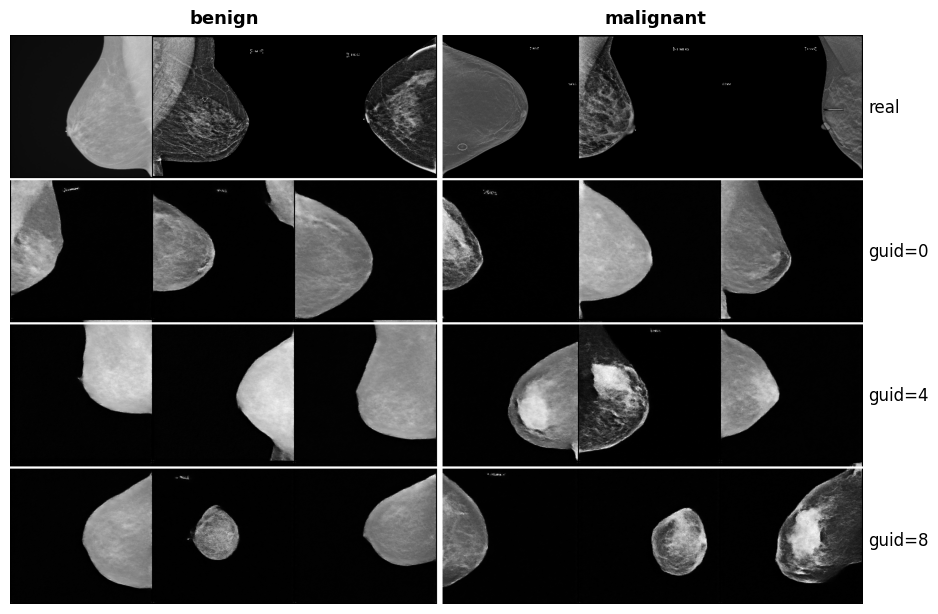

In [8]:
import torch, pathlib

# pick a file
file_path = pathlib.Path("visual_logs/124_DDPM_binary_20250718_215916-rows.pt")
rows_dict = torch.load(file_path)

real_row_full   = rows_dict["real"]                    # (2N,1,H,W)
fake_rows_full  = [rows_dict["guidances"][g]           # keep guidance order
                   for g in sorted(rows_dict["guidances"])]

# -------- now apply any KEEP_IDX, VIS_PER_CLASS you like ----------
KEEP_IDX        = [1, 3, 4]                            # e.g. choose which to keep
VIS_PER_CLASS   = len(KEEP_IDX)

def trim(t):
    n_orig = rows_dict["meta"]["n_per_class"]
    keep0  = torch.tensor(KEEP_IDX)
    keep1  = keep0 + n_orig
    return t[torch.cat([keep0, keep1])]

rows = [trim(real_row_full)] + [trim(r) for r in fake_rows_full]

# --------  reuse the existing plotting block  ---------------------
# (stack rows, add separators/labels, save PDF …)
# ---------------- stack & plot -------------------------------------
n_rows = len(rows)
n_cols = len(LABELS) * VIS_PER_CLASS          # 6 columns if keep=3

all_imgs = torch.cat(rows, 0)
grid = make_grid(all_imgs, nrow=n_cols, padding=2, value_range=(0, 1))
grid_img = grid.permute(1, 2, 0).cpu().numpy()

# ------- horizontal separators (rows) ---------------------------------
BAR_PX  = 4
PADDING = 2
ROW_H   = RESOLUTION + PADDING          # distance from one row-top to next

for k in range(1, n_rows):              # k = 1 … n_rows-1
    y = PADDING + k * ROW_H + (k - 1) * BAR_PX
    grid_img[y : y + BAR_PX, :, :] = 1.0

# ------- vertical separator (between benign | malignant) --------------
VBAR_PX     = 10                        # thicker than row bars
COL_GROUP_W = RESOLUTION + PADDING      # width of one image + right padding
x = PADDING + VIS_PER_CLASS * COL_GROUP_W   # left edge of first malignant image
grid_img[:, x : x + VBAR_PX, :] = 1.0       # paint white stripe

# ------- plot -------------------------------------------------------
fig, ax = plt.subplots(figsize=(11, 2.8 * n_rows))
ax.imshow(grid_img, cmap="gray")
ax.axis("off")

# column labels ------------------------------------------------------
x_vert       = x                                       # from earlier code
x_benign     = PADDING + VIS_PER_CLASS * COL_GROUP_W / 2
x_malignant  = x_vert + VBAR_PX + VIS_PER_CLASS * COL_GROUP_W / 2
ax.text(x_benign,    -15, "benign",    ha="center", va="bottom",
        fontsize=13, fontweight="bold")
ax.text(x_malignant, -15, "malignant", ha="center", va="bottom",
        fontsize=13, fontweight="bold")

# row labels (unchanged) --------------------------------------------
row_labels = ["real"] + [f"guid={g}" for g in GUIDE_SCALES]
for idx, txt in enumerate(row_labels):
    y_mid = PADDING + idx * (ROW_H + BAR_PX) + ROW_H // 2
    ax.text(grid_img.shape[1] + 10, y_mid, txt,
            va="center", fontsize=12)

plt.show()